<a href="https://colab.research.google.com/github/michaelnaderi/Google_Earth_Engine/blob/main/SARIMAX_Precipitation_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap as gee
import xarray as xr

In [2]:
!pip install xee
import xee

ee.Authenticate()
ee.Initialize(project = 'ee-mohammadmehdinaderii', opt_url = 'https://earthengine-highvolume.googleapis.com')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.8 MB/s eta 0:00:00


In [3]:
map = gee.Map(basemap = 'SATELLITE')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [4]:
roi = map.draw_last_feature.geometry()

In [5]:
collection = ee.ImageCollection("NOAA/PERSIANN-CDR").filterDate('2005','2024')

In [6]:
ds = xr.open_dataset(collection, engine = 'ee', crs = 'EPSG:4326', geometry = roi, scale = 0.27)

In [7]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:        (time: 6938, lon: 488, lat: 203)
Coordinates:
  * time           (time) datetime64[ns] 56kB 2005-01-01 ... 2023-12-31
  * lon            (lon) float64 4kB -27.7 -27.43 -27.16 ... 103.2 103.5 103.8
  * lat            (lat) float64 2kB 2.946 3.216 3.486 ... 56.95 57.22 57.49
Data variables:
    precipitation  (time, lon, lat) float32 3GB ...
Attributes: (12/20)
    date_range:               [410227200000, 1625011200000]
    description:              <p>PERSIANN-CDR is a daily quasi-global precipi...
    keywords:                 ['cdr', 'climate', 'geophysical', 'ncdc', 'noaa...
    period:                   1
    period_mapping:           [410227200000, 1625011200000]
    product_tags:             ['precipitation', 'persiann', 'geophysical', 'w...
    ...                       ...
    visualization_0_bands:    precipitation
    visualization_0_max:      50.0
    visualization_0_min:      0.0
    visualization_0_name:     Precipitation
    visualization_0_palette:  3907ff,03fff3,28ff25,fbff09,ff1105
    crs:                      EPSG:4326

In [8]:
ds_mean = ds.mean('time')

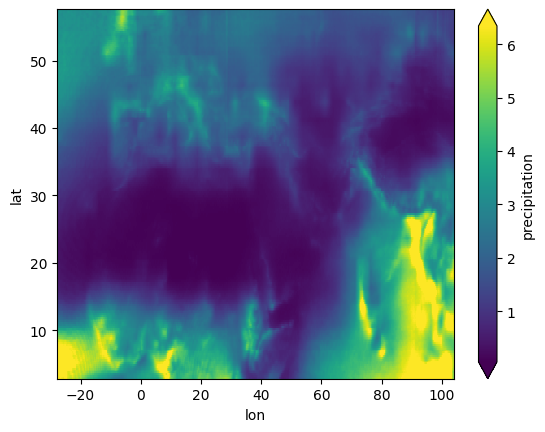

In [9]:
ds_mean.precipitation.plot(x = 'lon', y = 'lat', robust = True)

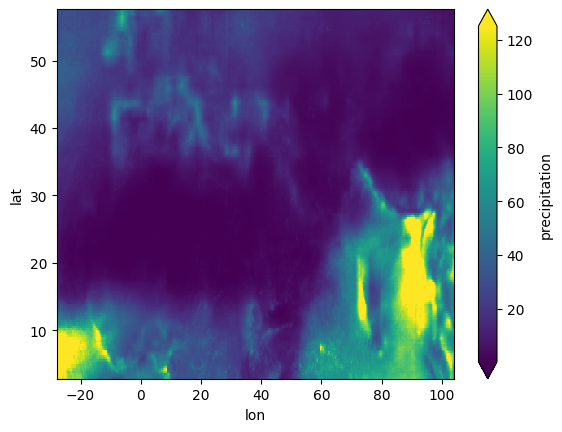

In [10]:
ds_var = ds.var('time')

ds_var.precipitation.plot(x = 'lon', y = 'lat', robust = True)


In [13]:
monthly = ds.resample(time = 'M').sum()

In [14]:
monthly

<xarray.Dataset> Size: 90MB
Dimensions:        (time: 228, lon: 488, lat: 203)
Coordinates:
  * lon            (lon) float64 4kB -27.7 -27.43 -27.16 ... 103.2 103.5 103.8
  * lat            (lat) float64 2kB 2.946 3.216 3.486 ... 56.95 57.22 57.49
  * time           (time) datetime64[ns] 2kB 2005-01-31 ... 2023-12-31
Data variables:
    precipitation  (time, lon, lat) float32 90MB 288.8 297.0 ... 24.32 23.37
Attributes: (12/20)
    date_range:               [410227200000, 1625011200000]
    description:              <p>PERSIANN-CDR is a daily quasi-global precipi...
    keywords:                 ['cdr', 'climate', 'geophysical', 'ncdc', 'noaa...
    period:                   1
    period_mapping:           [410227200000, 1625011200000]
    product_tags:             ['precipitation', 'persiann', 'geophysical', 'w...
    ...                       ...
    visualization_0_bands:    precipitation
    visualization_0_max:      50.0
    visualization_0_min:      0.0
    visualization_0_name:     Precipitation
    visualization_0_palette:  3907ff,03fff3,28ff25,fbff09,ff1105
    crs:                      EPSG:4326

In [15]:
point = monthly.sel(lon = -82.89531250000002, lat = 38.28019157651279, method ='nearest')

point

<xarray.Dataset> Size: 3kB
Dimensions:        (time: 228)
Coordinates:
    lon            float64 8B -27.7
    lat            float64 8B 38.32
  * time           (time) datetime64[ns] 2kB 2005-01-31 ... 2023-12-31
Data variables:
    precipitation  (time) float32 912B 81.62 50.48 219.7 ... 175.5 121.5 180.0
Attributes: (12/20)
    date_range:               [410227200000, 1625011200000]
    description:              <p>PERSIANN-CDR is a daily quasi-global precipi...
    keywords:                 ['cdr', 'climate', 'geophysical', 'ncdc', 'noaa...
    period:                   1
    period_mapping:           [410227200000, 1625011200000]
    product_tags:             ['precipitation', 'persiann', 'geophysical', 'w...
    ...                       ...
    visualization_0_bands:    precipitation
    visualization_0_max:      50.0
    visualization_0_min:      0.0
    visualization_0_name:     Precipitation
    visualization_0_palette:  3907ff,03fff3,28ff25,fbff09,ff1105
    crs:                      EPSG:4326

<Axes: xlabel='time'>

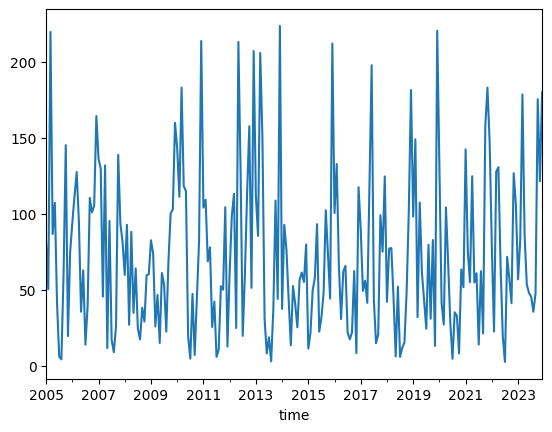

In [16]:
df = point.to_dataframe()['precipitation']

df

df.plot()

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [21]:
model = SARIMAX(df, order = (1,1,1), seasonal_order = (1,1,0,120)) # this gives a better result
result = model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='time'>

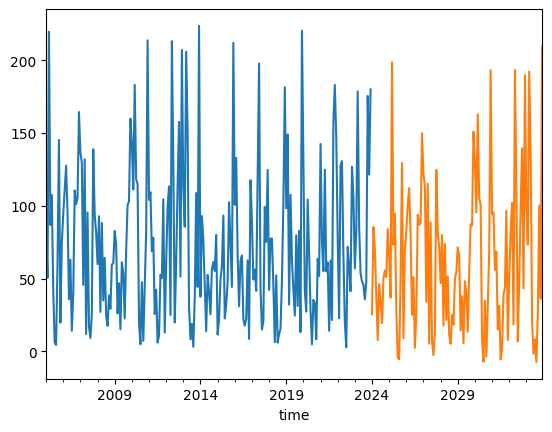

In [22]:
forecast = result.get_forecast(steps = 10 * 12)

df.plot()
forecast.predicted_mean.plot()

In [23]:
forecast.predicted_mean.to_csv('pr_forecasted.csv')